In [1]:
import pandas as pd
from os import walk
from os.path import join
import matplotlib.pyplot as plt
import nltk 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import numpy as np
from sklearn.model_selection import train_test_split
from SpamClassifier_utils import *


In [76]:
ex = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_2'
NONSPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
NONSPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT =1
NONSPAM_CAT =0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Testing/test-data.txt'

TOKEN_SPAM_PROB_FILE = 'SpamData/03_Testing/prob-spam.txt'
TOKEN_NONSPAM_PROB_FILE = 'SpamData/03_Testing/prob-nonspam.txt'
TOKEN_PROB_FILE = 'SpamData/03_Testing/prob-alltokens.txt' 

VOCAB_SIZE = 2500


In [3]:
stream = open(ex, encoding='latin-1')
message = stream.read()
stream.close()
#print(message)

In [4]:
stream = open(ex, encoding='latin-1')
is_body = False
lines = []
for line in stream:
    if is_body:
        lines.append(line)
    elif line =='\n':
        is_body = True
stream.close()
email_body = '\n'.join(lines)
#print(email_body)


Generator Function

In [5]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()
spam_emails.shape


(1898, 2)

In [6]:
nonspam_emails = df_from_directory(NONSPAM_1_PATH, NONSPAM_CAT)
nonspam_emails = nonspam_emails.append(df_from_directory(NONSPAM_2_PATH, NONSPAM_CAT))
nonspam_emails.shape

(3901, 2)

In [7]:
data = pd.concat([spam_emails, nonspam_emails])
print('Shape: ',data.shape)
data.head()

Shape:  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [8]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


DATA CLEANING

In [9]:
#check for null values
data['MESSAGE'].isnull().values.any()
#check for empty emails
(data['MESSAGE'].str.len()==0).any() #returns true
(data['MESSAGE'].str.len()==0).sum()
#locating empty emails

data[data['MESSAGE'].str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [10]:
#removing system file entries
data = data.drop(['cmds'])
data.shape

(5796, 2)

In [11]:
doc_ids = range(0,len(data.index))
data['DOC_ID'] = doc_ids
data['FILE_NAME'] = data.index
data.head()
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [12]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


In [13]:
#save to files using pandas
data.to_json(DATA_JSON_FILE)

DATA VISUALISATION

In [14]:
data.CATEGORY.value_counts()
spam = data.CATEGORY.value_counts()[1]
nonspam = data.CATEGORY.value_counts()[0]

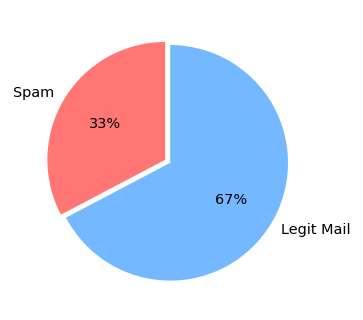

In [15]:
cat_name = ['Spam', 'Legit Mail']
sizes = [spam, nonspam]
custom_colors=['#ff7675', '#74b9ff']
plt.figure(figsize = [3,3], dpi = 130)
plt.pie(sizes, labels= cat_name, textprops = {'fontsize':8}, startangle=90, autopct = '%1.0f%%' , colors= custom_colors , explode=[0,0.05])
plt.show()

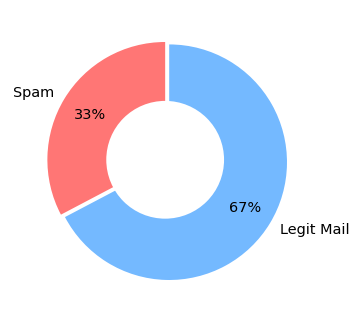

In [16]:
cat_name = ['Spam', 'Legit Mail']
sizes = [spam, nonspam]
custom_colors=['#ff7675', '#74b9ff']
plt.figure(figsize = [3,3], dpi = 130)
plt.pie(sizes, labels= cat_name, textprops = {'fontsize':8}, startangle=90, autopct = '%1.0f%%' , colors= custom_colors, pctdistance = 0.75, explode=[0,0.04])

#draw circle

circle = plt.Circle((0,0), radius=0.5, fc='white')
plt.gca().add_artist(circle)

Natural Language Processing

Text Pre Processing

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aashka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aashka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
data_list = data['MESSAGE'].apply(clean_msg)

C:\Users\Aashka\AppData\Local\Programs\Python\Python38-32\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [20]:
spam_id = data[data.CATEGORY == 1].index
nonspam_id = data[data.CATEGORY == 0].index
nonspam_data_list = data_list.loc[nonspam_id]
spam_data_list = data_list.loc[spam_id]

In [21]:
words_data0 = [item for sublist in nonspam_data_list for item in sublist]
words_data1 = [item for sublist in spam_data_list for item in sublist]

normal_words = pd.Series(words_data0).value_counts()
spam_words = pd.Series(words_data1).value_counts()
spam_words.shape[0]


13242

In [22]:
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

In [23]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [24]:
data_words = [item for sublist in data_list for item in sublist]


In [25]:
unique_words = pd.Series(data_words).value_counts()
print('Number of unique words: ', unique_words.shape[0])
freq_words = unique_words[0:VOCAB_SIZE]
print('Top 10 common words')
freq_words.head(10).index


Number of unique words:  27334
Top 10 common words


Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work'],
      dtype='object')

In [26]:
word_id = list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': freq_words.index.values}, index=word_id)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [27]:
vocab.to_csv(WORD_ID_FILE, header=vocab.VOCAB_WORD.name, index_label=vocab.index.name)

In [28]:
word_columns_df = pd.DataFrame.from_records(data_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [29]:
word_columns_df.shape #no of emails x maximum words

(5796, 7671)

Splitting the data into training and testing data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data['CATEGORY'], test_size=0.3, random_state=42)

In [31]:
print("Number of training samples: ",X_train.shape[0])

Number of training samples:  4057


In [32]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [33]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

Create Sparse Matrix

In [34]:
word_index = pd.Index(vocab['VOCAB_WORD'])

In [35]:
sparse_train_df = sparse_matrix(X_train, word_index, y_train)

In [36]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1236
2,0,4844,1,503
3,0,4844,1,308
4,0,4844,1,254


In [37]:
sparse_train_df.shape

(429250, 4)

In [38]:
#Combine occurences with groupby() method
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped = train_grouped.reset_index()
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258366,5795,2026,0,1
258367,5795,2037,0,2
258368,5795,2271,0,1
258369,5795,2325,0,1
258370,5795,2382,0,1


In [39]:
vocab.at[2034,'VOCAB_WORD']

'rose'

In [40]:
#saving as text file
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt = '%d')

In [41]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [42]:
sparse_test_df = sparse_matrix(X_test, word_index, y_test)
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')

Training the model

In [43]:
#read and load features from .txt files into np arrays
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE, delimiter=' ', dtype=int)
sparse_test_data = np.loadtxt(TEST_DATA_FILE, delimiter=' ', dtype=int)

In [44]:
print('Nr of rows in training file: ', sparse_train_data.shape[0])
print('Nr of rows in test file: ', sparse_test_data.shape[0])

Nr of rows in training file:  258371
Nr of rows in test file:  117783


In [45]:
print('Nr of emails in training file: ', np.unique(sparse_train_data[:, 0]).size)
print('Nr of email in test file: ', np.unique(sparse_test_data[:, 0]).size)

Nr of emails in training file:  4013
Nr of email in test file:  1724


In [46]:
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)

In [47]:
full_train_data.head()

,DOC_IDS,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0.0,0,1,0,0,1,2,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1.0,0,1,7,1,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2.0,0,1,6,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3.0,0,1,6,0,0,2,4,0,3,14,...,0,0,0,0,0,0,0,0,0,0
4.0,0,1,5,1,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#Calculating Token Probabilities for Bayes Theorem

#Calculating the probability of Spam messages

total_mails = full_train_data.CATEGORY.size
spam_mails = full_train_data.CATEGORY.sum()
probs_spam = spam_mails/total_mails
print(probs_spam)


0.310989284824321


In [49]:
#Total number of words/tokens

full_train_features = full_train_data.loc[:,full_train_data.columns != 'CATEGORY']
full_train_features.head()

,DOC_IDS,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,1,2,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1.0,0,7,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,6,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,6,0,0,2,4,0,3,14,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,5,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
email_lengths = full_train_features.sum(axis=1)
email_lengths.shape

(4013,)

In [51]:
email_lengths.head()

DOC_ID
0.0     87
1.0     53
2.0     40
3.0    183
4.0     43
dtype: int64

In [52]:
total_words = email_lengths.sum()
total_words

429250

In [54]:
#Number of tokens in spam and ham emails

spam_lengths = email_lengths[full_train_data.CATEGORY==1]
spam_wc = spam_lengths.sum()

nonspam_lengths = email_lengths[full_train_data.CATEGORY==0]
nonspam_wc = nonspam_lengths.sum()

print('total number of words in spam emails: ', spam_wc)
print('total number of words in non spam emails: ', nonspam_wc)


total number of words in spam emails:  176368
total number of words in non spam emails:  252882


In [60]:
print('Average number of words in spam emails: {:.0f}'.format(spam_wc/spam_lengths.shape[0]))
print('Average number of words in non spam emails: {:.0f}'.format(nonspam_wc/nonspam_lengths.shape[0]))

Average number of words in spam emails: 141
Average number of words in non spam emails: 91


In [61]:
#Summing the tokens in spam 

full_train_features.shape

(4013, 2501)

In [62]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY==1]

train_spam_tokens.head()

,DOC_IDS,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,1,2,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1.0,0,7,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,6,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,6,0,0,2,4,0,3,14,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,5,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
train_spam_tokens.shape

(1248, 2501)

In [64]:
summed_spam_tokens = train_spam_tokens.sum(axis=0) +1
summed_spam_tokens.shape

(2501,)

In [67]:
#Summing the tokens in non spam

train_nonspam_tokens = full_train_features.loc[full_train_data.CATEGORY==0]
summed_nonspam_tokens = train_nonspam_tokens.sum(axis=0) +1

In [68]:
#P(token|spam) - probability a token occurs given the email is spam

prob_tokens_spam = summed_spam_tokens / (spam_wc + VOCAB_SIZE)
prob_tokens_spam[:5]


DOC_IDS    0.000006
0          0.012182
1          0.005227
2          0.006804
3          0.011304
dtype: float64

In [69]:
prob_tokens_spam.sum()

1.0000055907149406

In [71]:
#P(token|nonspam) - probability a token occurs given the email is spam

prob_tokens_nonspam = summed_nonspam_tokens / (nonspam_wc + VOCAB_SIZE)
prob_tokens_nonspam.sum()

1.0000039157027512

In [72]:
#P(token)

prob_tokens = full_train_features.sum(axis=0) / total_words

In [73]:
prob_tokens.sum()

1.0

In [77]:
#Save Trained model

np.savetxt(TOKEN_SPAM_PROB_FILE, prob_tokens_spam)
np.savetxt(TOKEN_NONSPAM_PROB_FILE, prob_tokens_nonspam)
np.savetxt(TOKEN_PROB_FILE, prob_tokens)